# Свёрточная нейронная сеть

In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import (precision_score, f1_score, accuracy_score, \
                            recall_score, classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

import os

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
def rgb_to_gray(img):
    R = np.array(img[:, :, 0])
    G = np.array(img[:, :, 1])
    B = np.array(img[:, :, 2])
    grayImage = np.dot(img, [0.299, 0.587, 0.114])
    return R, G, B, grayImage

def Accuracy_model(test, predict):
    test = test.T
    predict = to_categorical(predict).T
    Accuracy = pd.DataFrame(columns=['Classes', 'Accuracy', 'Precision', 'Recall', 'f1-score'])
    Accuracy['Classes']= ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
    Accuracy['Accuracy'] = [ np.around(accuracy_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['Precision'] = [ np.around(precision_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['Recall'] = [ np.around(recall_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['f1-score'] = [ np.around(f1_score(test[i], predict[i])*100, 2) for i in range(10)]
    
    return Accuracy

In [ ]:
def model_compile(branch = 1, layer = 1):

    if branch < 1: branch = 1
    if layer < 1: layer = 1

    inp = Input((32,32,3))
    # реализуем простую модель AlexNet
    x0 = Conv2D(64, 4, strides=2 ,activation='relu', padding='same')(inp)
    x0 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x0)

    if layer > 1:
        x0 = Conv2D(128, 4, strides=2 ,activation='relu', padding='same')(x0)
        x0 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x0)

    x0 = Dropout(0.25)(x0)
    x0 = Flatten()(x0)

    if layer > 2:
        x0 = Dense(512, activation='relu')(x0)
        x0 = Dropout(0.5)(x0)

    x_imp_0 = []
    x_imp_1 = [x0]
    # слой обработки красного спектра
    if branch > 1:
        x1 = Lambda(lambda x: x[:, :, :, 0])(inp)
        x1 = Conv1D(64, 4, strides=2 ,activation='relu', padding='same')(x1)
        x1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(x1)
        x1 = Dropout(0.25)(x1)

        if layer > 1:
            x11 = Flatten()(x1)
            x11 = Dense(512, activation='relu')(x11)
            x11 = Dropout(0.5)(x11)
            x_imp_1.append(x11)

        x_imp_0.append(x1)
        

    # слой обработки зелёного спектра
    if branch > 2:
        x2 = Lambda(lambda x: x[:, :, :, 1])(inp)
        x2 = Conv1D(64, 4, strides=2 ,activation='relu', padding='same')(x2)
        x2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(x2)
        x2 = Dropout(0.25)(x2)

        if layer > 1:
            x22 = Flatten()(x2)
            x22 = Dense(512, activation='relu')(x22)
            x22 = Dropout(0.5)(x22)
            x_imp_1.append(x22)

        x_imp_0.append(x2)
        

    # слой обработки синего спектра
    if branch > 3:
        x3 = Lambda(lambda x: x[:, :, :, 2])(inp)
        x3 = Conv1D(64, 4, strides=2 ,activation='relu', padding='same')(x3)
        x3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(x3)
        x3 = Dropout(0.25)(x3)

        if layer > 1:
            x33 = Flatten()(x3)
            x33 = Dense(512, activation='relu')(x33)
            x33 = Dropout(0.5)(x33)
            x_imp_1.append(x33)

        x_imp_0.append(x3)
        

    # слой обработки серого спектра
    if branch > 4:
        x4 = Lambda(lambda x: tf.tensordot(x, [0.299, 0.587, 0.114], axes=1))(inp)
        x4 = Conv1D(64, 4, strides=2 ,activation='relu', padding='same')(x4)
        x4 = MaxPooling1D(pool_size=2, strides=2, padding='same')(x4)
        x4 = Dropout(0.25)(x4)
        
        if layer > 1:
            x44 = Flatten()(x4)
            x44 = Dense(512, activation='relu')(x44)
            x44 = Dropout(0.5)(x44)
            x_imp_1.append(x44)

        x_imp_0.append(x4)
        

    # слой обработки общего спектра
    if branch > 1:
        x = Concatenate(  axis = 1 )(x_imp_0)
        x = Conv1D(64, 4, strides=1 ,activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.25)(x)
        x = Flatten()(x)

        if layer > 1:
            x = Dense(512, activation='relu')(x)
            x = Dropout(0.5)(x)

        x_imp_1.append(x)

    # Соберем полную модель сети от входа к выходу
    x = Concatenate()(x_imp_1)
    x = Dense(2048, activation='relu')(x)
    if layer > 1:
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
    out = Dense(10, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='Adam',metrics=['accuracy'])

    return model

def model_fit(model, x_train, y_train, x_test, y_test, epochs = 15, batch_size = 128, data_augmentation = False):

    if not data_augmentation:
        with tf.device("GPU:0"):
            model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    workers=-1,
                    verbose=0)
    else:
        # Препроцессинг и data augmentation в реальном времени:
        datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False, 
            zca_epsilon=1e-06, 
            rotation_range=5, 
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0., 
            zoom_range=0., 
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)

        with tf.device("GPU:0"):
            # запуск data augmentation через fit_generator
            model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                                            epochs=epochs,
                                            validation_data=(x_test, y_test),
                                            workers=-1,
                                            verbose=1)

    return model
  

In [ ]:
# установка параметров нейросети
num_classes = 10
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test_) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test_, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


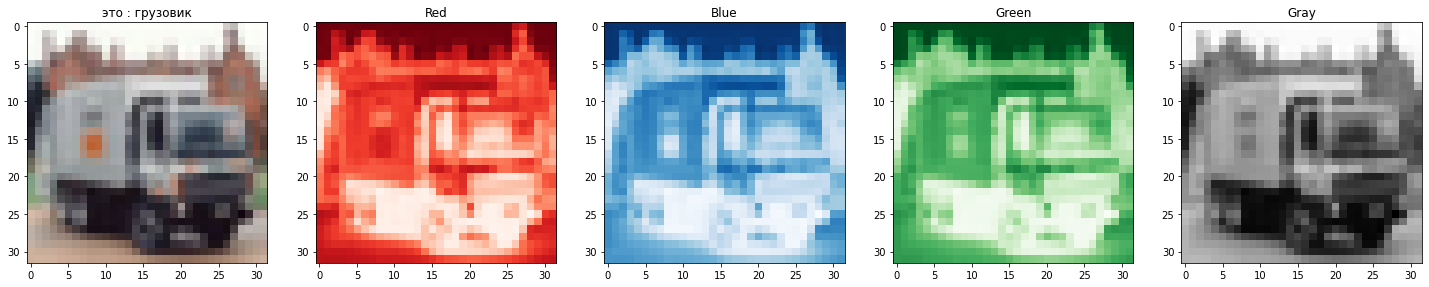

In [ ]:
N = 11

image = x_test[N, :,:,:]
label = classes[np.argmax(y_test[N,:])]
R, G, B, grayImage = rgb_to_gray(image)  


plt.figure(figsize=(25, 25))
plt.subplot(151)
plt.imshow(image)
plt.title(f'это : {label}')
plt.subplot(152)
plt.imshow(R, cmap='Reds')
plt.title('Red')
plt.subplot(153)
plt.imshow(B, cmap='Blues')
plt.title('Blue')
plt.subplot(154)
plt.imshow(G, cmap='Greens')
plt.title('Green')
plt.subplot(155)
plt.imshow(grayImage, cmap='gray')
plt.title('Gray')
plt.show()

## Практическое задание

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)


### Строим сеть

In [ ]:
# Обучаем модель
best_model = None
accuracy = 0
for i in range(1,6):
    for j in range(1,3):
        model = model_compile(branch = i, layer = j)
        model = model_fit(model, x_train, y_train, x_test, y_test)
        # проверка работы обученной модели
        print(f'\nModel с {i} нитью и {j} слоем')
        scores = model.evaluate(x_test, y_test, verbose=1)
        print(f'Test loss: {scores[0]:.4f}')
        print(f'Test accuracy: {scores[1]*100:.2f} %')

        if scores[1]*100 > accuracy:
            accuracy = scores[1]*100
            best_model = model



Model с 1 нитью и 1 слоем
313/313 [==============================] - 1s 3ms/step - loss: 1.2150 - accuracy: 0.6944
Test loss: 1.2150
Test accuracy: 69.44 %

Model с 1 нитью и 2 слоем
313/313 [==============================] - 1s 3ms/step - loss: 0.8574 - accuracy: 0.7087
Test loss: 0.8574
Test accuracy: 70.87 %

Model с 2 нитью и 1 слоем
313/313 [==============================] - 1s 3ms/step - loss: 1.1405 - accuracy: 0.7045
Test loss: 1.1405
Test accuracy: 70.45 %

Model с 2 нитью и 2 слоем
313/313 [==============================] - 1s 3ms/step - loss: 0.8643 - accuracy: 0.7068
Test loss: 0.8643
Test accuracy: 70.68 %

Model с 3 нитью и 1 слоем
313/313 [==============================] - 1s 4ms/step - loss: 1.2232 - accuracy: 0.7020
Test loss: 1.2232
Test accuracy: 70.20 %

Model с 3 нитью и 2 слоем
313/313 [==============================] - 1s 4ms/step - loss: 0.8613 - accuracy: 0.7027
Test loss: 0.8613
Test accuracy: 70.27 %

Model с 4 нитью и 1 слоем
313/313 [======================

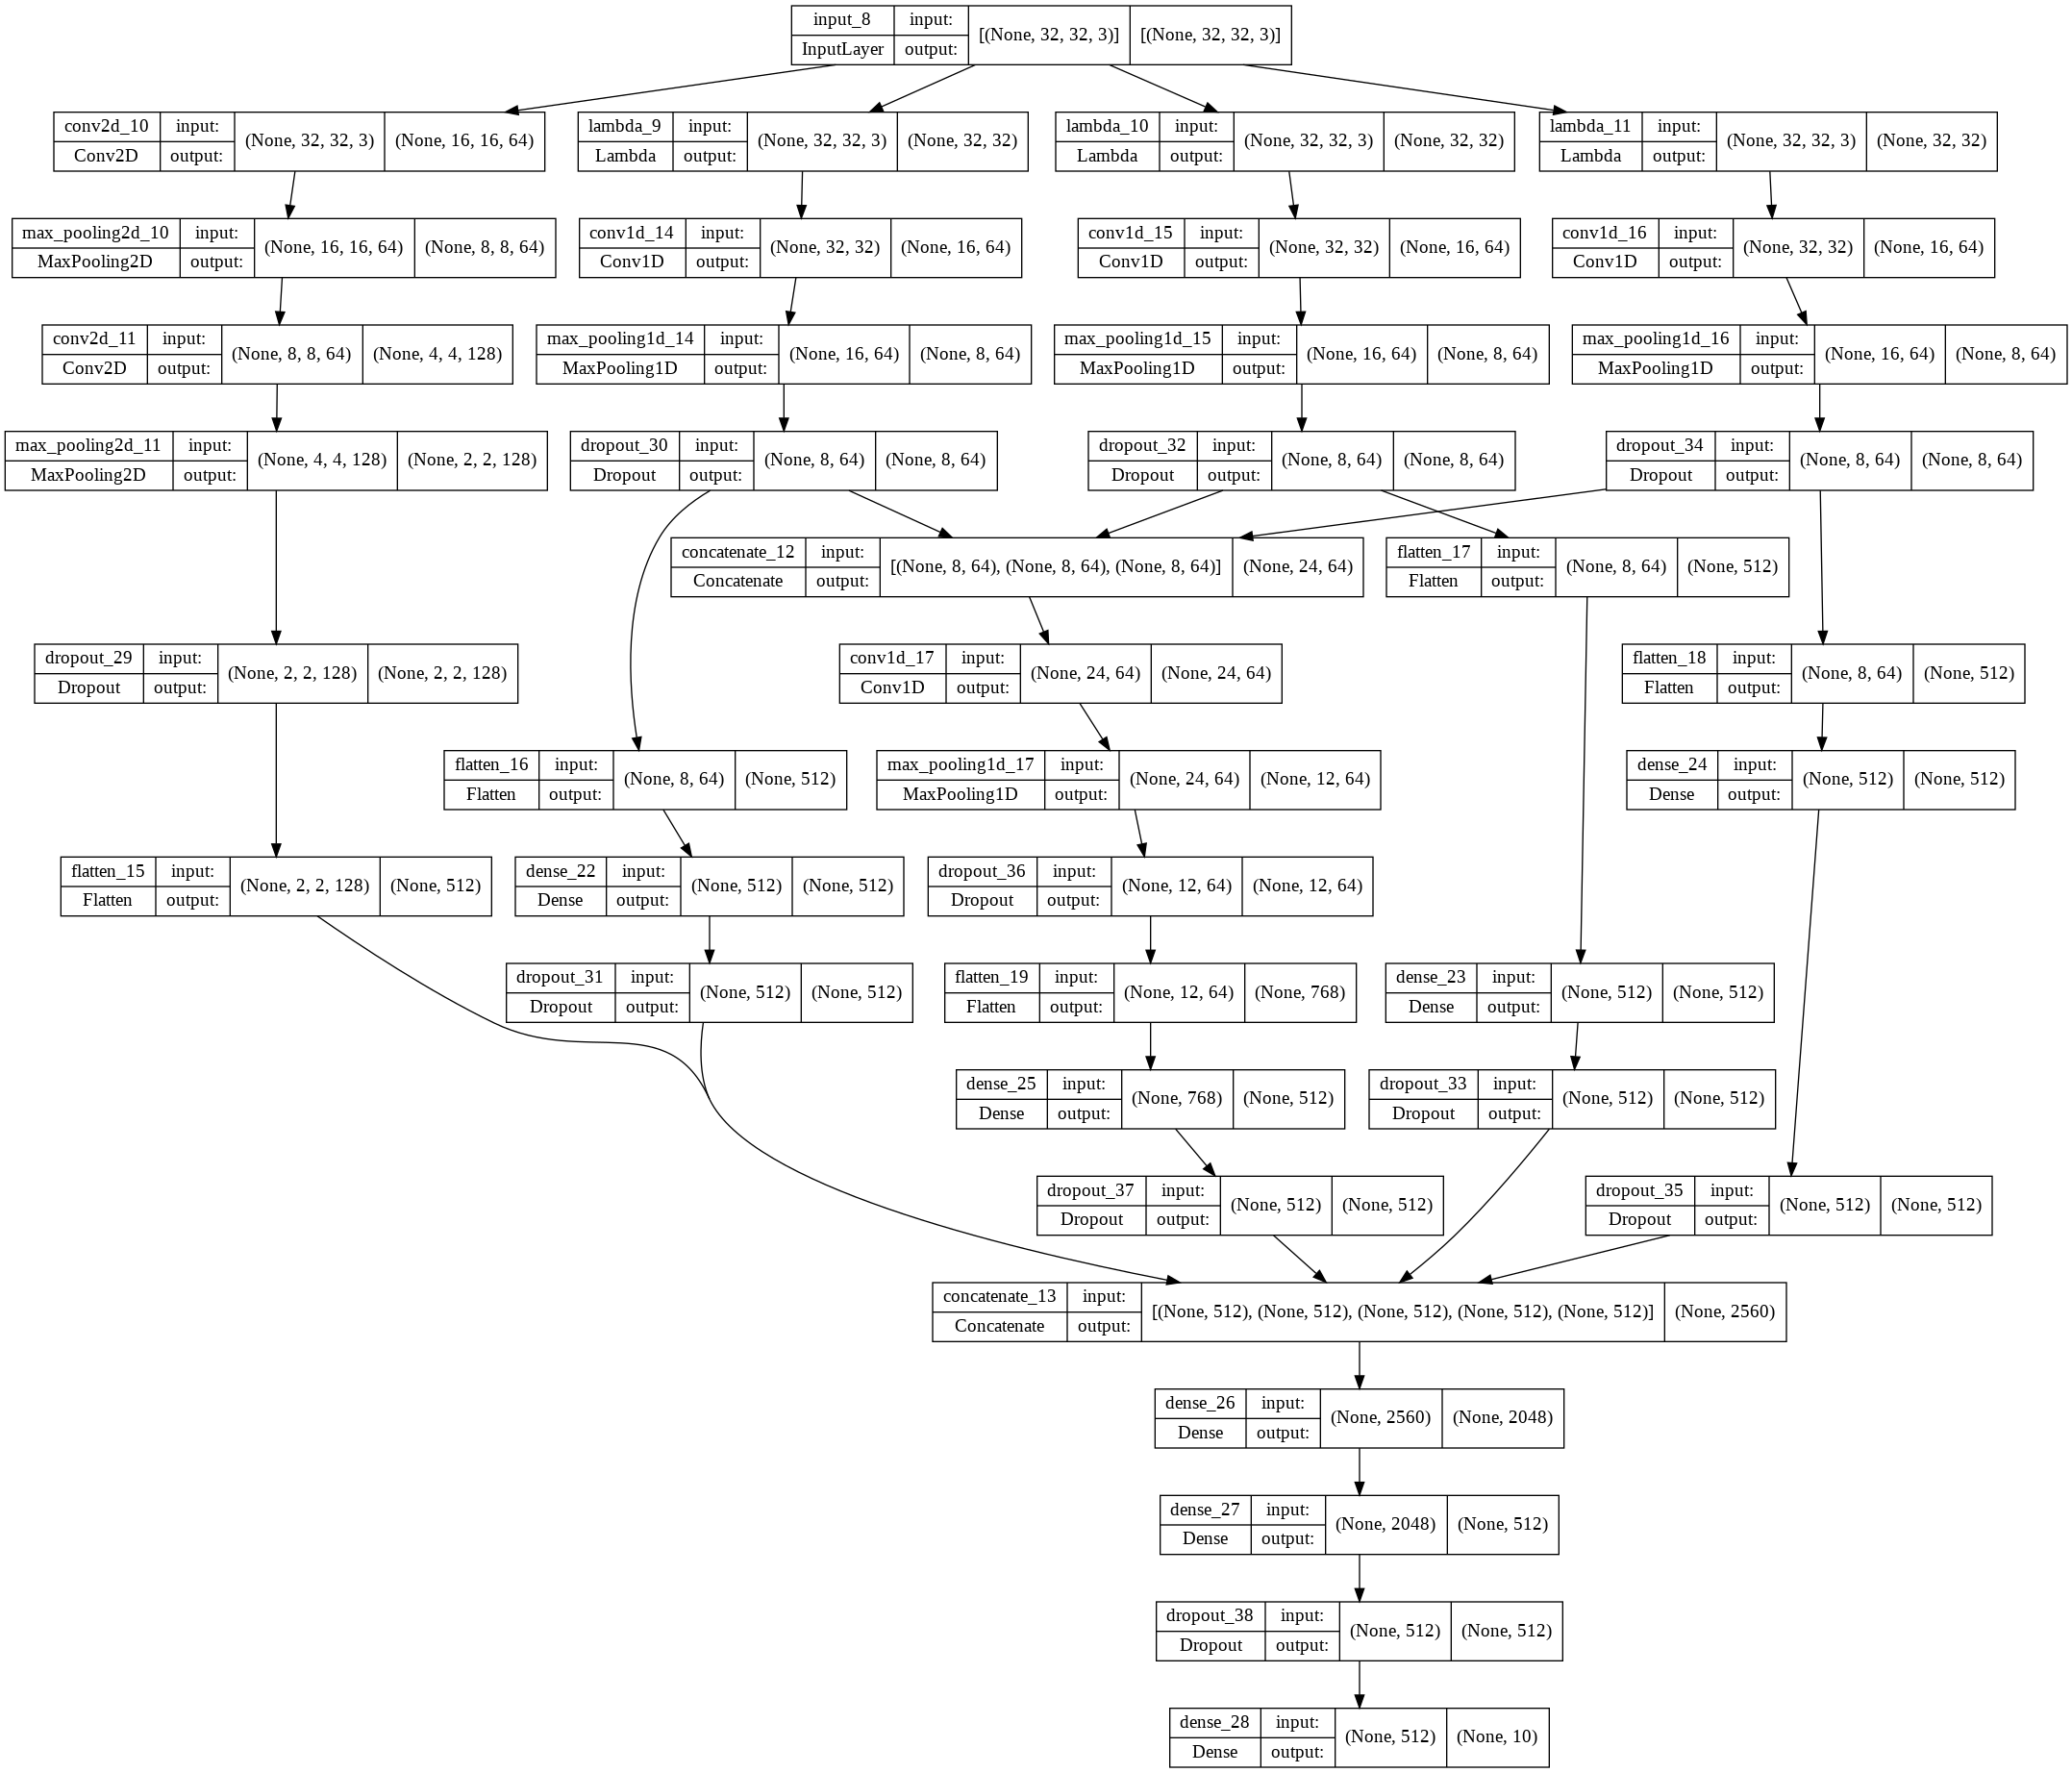

In [ ]:
# Посмотрим на лучшую модель Keras
plot_model(best_model,'model_stek.png', show_shapes=True)

#### Посмотрим на точность нашей обученной нейронной сети:

In [ ]:
predictions = best_model.predict(x_test)
y_pred = np.argmax(predictions,axis=1)

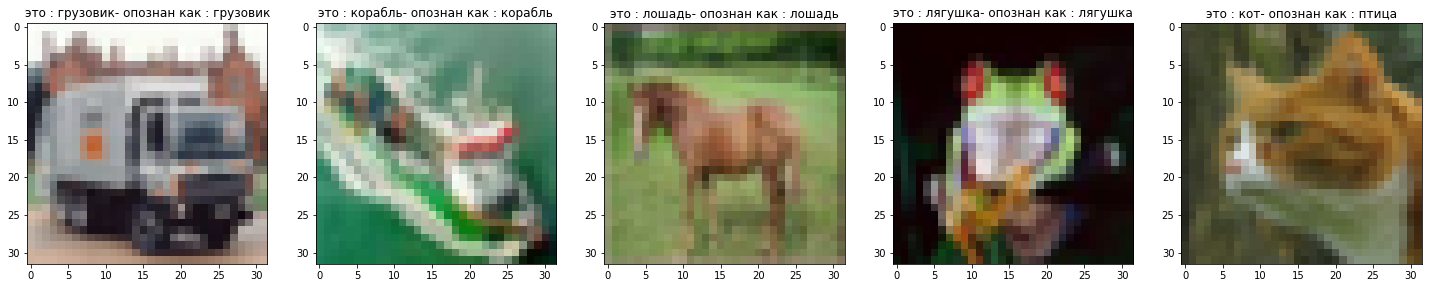

In [ ]:
N = [11, 15, 48, 102, 91]
number =150
plt.figure(figsize=(25, 25))

for i in N:
    y_t = np.argmax(y_test[i:i+1], axis = 1 )
    y_i = np.argmax(predictions[i:i+1], axis = 1 )
    number += 1
    plt.subplot(number)
    plt.imshow(x_test[i][:,:,:])
    plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

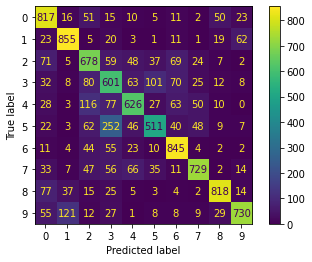

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

In [ ]:
Accuracy_model(y_test, y_pred)

,Classes,Accuracy,Precision,Recall,f1-score
0,самолет,94.65,69.89,81.7,75.33
1,автомобиль,96.51,80.74,85.5,83.05
2,птица,92.46,61.08,67.8,64.27
3,кот,90.15,50.63,60.1,54.96
4,олень,93.61,70.26,62.6,66.21
5,собака,92.84,69.24,51.1,58.80
6,лягушка,95.58,74.65,84.5,79.27
7,лошадь,95.64,81.54,72.9,76.98
8,корабль,96.78,85.39,81.8,83.55
9,грузовик,95.98,84.69,73.0,78.41


### Вывод: добавление новых нитей и слоёв особых преимуществ не дало, но это скорее всего из-за изначальной хорошей конфигурации сверточной нейронной сети. 